Exercício baseado no problema publicado no Kaggle: https://www.kaggle.com/chrizzles/swiss-banknote-conterfeit-detection

**Objetivo:** desenvolver um modelo de classificação capaz de identificar dinheiro falso baseado nas dimensões de uma nota

**Proposta:**
- Efetuar uma análise exploratória dos dados do dataset
- Identificar possíveis enviesamento dos dados
- Realizar testes de hipóteses analisando a variância dos dados
- Testes de normalidade
- Identificar possíveis correlações
- Se necessário, aplicar técnicas de geração de amostras artificiais
- Aplicar técnicas de amostragem que diminuam ao máximo um possível overfitting
- Aplicar técnicas de normalização e regularização, onde aplicável
- Descobrir qual algoritmo tem o melhor desempenho entre Naïve Bayes, Regressão Logística e Árvore de Decisão
- Usar técnicas de validação cruzada
- Validar resultado com matriz de confusão
- Analisar o grau de variação entre os resutados de teste

Contato: https://www.linkedin.com/in/vinicius-g-9364885a/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.stats import shapiro
from scipy.stats import norm

abs_path = os.getcwd()

# 1. Obtém o dataset através da API do Kaggle

In [2]:
parquet_file = "banknotes.parquet"
csv_file = "banknotes.csv"
zip_file_name = "swiss-banknote-conterfeit-detection.zip"

if os.path.isfile(parquet_file):
    print ("There is a parquet file!!!")
    dataset = pd.read_parquet(parquet_file)
else:
    """
    Obtém o dataset compactado em .zip, 
    extrai o arquivo .csv,
    deleta o arquivo .zip
    carrega o arquivo no jupyter,
    deleta o arquivo .csv,
    e gera um arquivo .parquet
    """
    print ("There is no file")
    !kaggle datasets download -d chrizzles/swiss-banknote-conterfeit-detection
    with zipfile.ZipFile(zip_file_name,"r") as zip_ref:
        zip_ref.extractall(abs_path)
    os.remove(file_name)
    dataset = pd.read_csv(csv_file)
    dataset.to_parquet(parquet_file, engine='pyarrow')
    os.remove(csv_file)
    
dataset

There is a parquet file!!!


,conterfeit,Length,Left,Right,Bottom,Top,Diagonal
0,0,214.8,131.0,131.1,9.0,9.7,141.0
1,0,214.6,129.7,129.7,8.1,9.5,141.7
2,0,214.8,129.7,129.7,8.7,9.6,142.2
3,0,214.8,129.7,129.6,7.5,10.4,142.0
4,0,215.0,129.6,129.7,10.4,7.7,141.8
...,...,...,...,...,...,...,...
195,1,215.0,130.4,130.3,9.9,12.1,139.6
196,1,215.1,130.3,129.9,10.3,11.5,139.7
197,1,214.8,130.3,130.4,10.6,11.1,140.0
198,1,214.7,130.7,130.8,11.2,11.2,139.4


# 2. Análise Exploratória dos Dados

In [3]:
dataset.shape

(200, 7)

**análise:** através do resultado "false" obtido abaixo, foi provado que:
- Todos os elementos possuem todos os dados, portanto não se faz necessário a remoção de nenhum deles da base de dados, bem como não se faz necessário utilizar nenhuma técnica de preenchimento de dado (ex.: interpolação, média, moda e etc.).
- Não há colunas com excesso de dados nulos, portanto, se for necessário eliminar alguma coluna, não será por este motivo, mas simpor algum outro como baixa correlação com a variável de resposta.

In [4]:
dataset.isnull().sum()

conterfeit    0
Length        0
Left          0
Right         0
Bottom        0
Top           0
Diagonal      0
dtype: int64

In [5]:
dataset.dtypes

conterfeit      int64
Length        float64
Left          float64
Right         float64
Bottom        float64
Top           float64
Diagonal      float64
dtype: object

**análise:** abaixo é possível notar a necessidade da normalização das variáveis explicativas, e que elas são variáveis contínuas.

In [6]:
dataset.describe()

,conterfeit,Length,Left,Right,Bottom,Top,Diagonal
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.500000,214.896000,130.121500,129.956500,9.417500,10.650500,140.483500
std,0.501255,0.376554,0.361026,0.404072,1.444603,0.802947,1.152266
min,0.000000,213.800000,129.000000,129.000000,7.200000,7.700000,137.800000
25%,0.000000,214.600000,129.900000,129.700000,8.200000,10.100000,139.500000
50%,0.500000,214.900000,130.200000,130.000000,9.100000,10.600000,140.450000
75%,1.000000,215.100000,130.400000,130.225000,10.600000,11.200000,141.500000
max,1.000000,216.300000,131.000000,131.100000,12.700000,12.300000,142.400000


**análise:** a coluna da variável de resposta, 'conterfeit', está perfeitamente balanceada entre as duas classes fornecidas. Portanto, não é necessário nenhuma técnica para remover ou criar elementos artificiais devido a algum desbalanceamento entre as classes.

In [7]:
np.unique(dataset['conterfeit'], return_counts=True)

(array([0, 1], dtype=int64), array([100, 100], dtype=int64))

**análise:** os gráficos de distribuição abaixo também provam que se faz necessário a normalização das variáveis explicativas. Além de mostrar a variedade de tipos de distribuições entre elas: bimodal, normal, enviesada à direita e à esquerda

<ipython-input-9-272ab7815afe>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(x.columns)/2, count+1)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-9-272ab7815afe>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(x.columns)/2, count+1)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will b

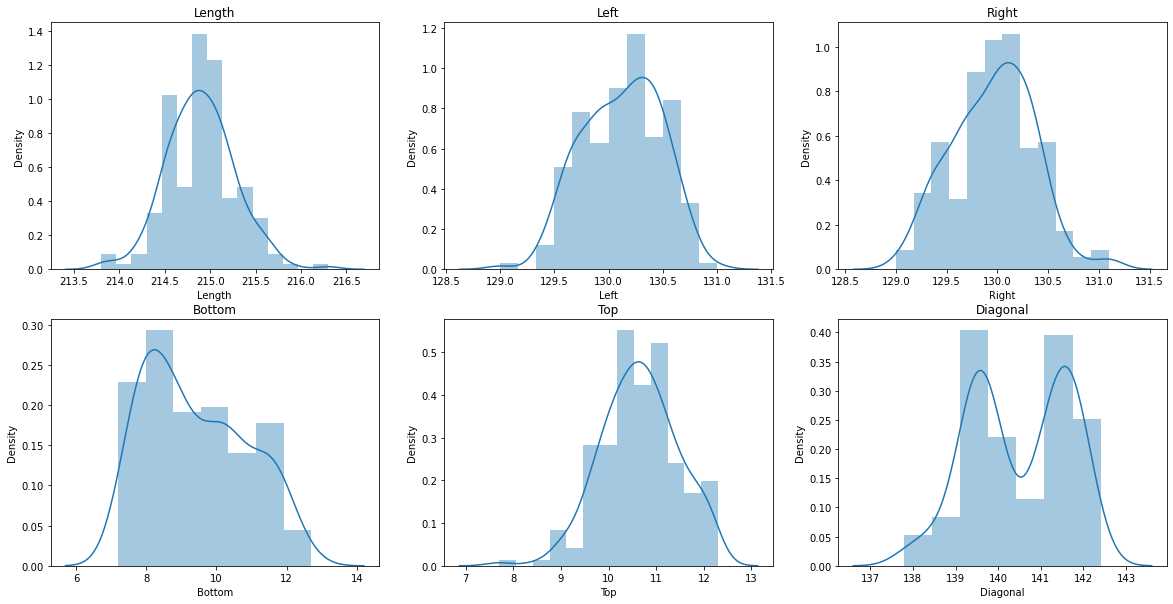

In [9]:
plt.figure(figsize=(20,10))
for count, column in enumerate(x.columns):
    plt.subplot(2, len(x.columns)/2, count+1)
    plt.title(column)
    plt.subplot(sns.distplot(dataset[column]))
plt.show()
plt.close()

**análise:** os box plots abaixo mostram que existem alguns outliers.

<ipython-input-10-7d9ebfda06e0>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(x.columns)/2, count+1)
<ipython-input-10-7d9ebfda06e0>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(x.columns)/2, count+1)
<ipython-input-10-7d9ebfda06e0>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(x.columns)/2, count+1)
<ipython-input-10-7d9ebfda06e0>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(x.columns)/2, count+1)
<ipython-input-10-7d9ebfda06e0>:3: Matpl

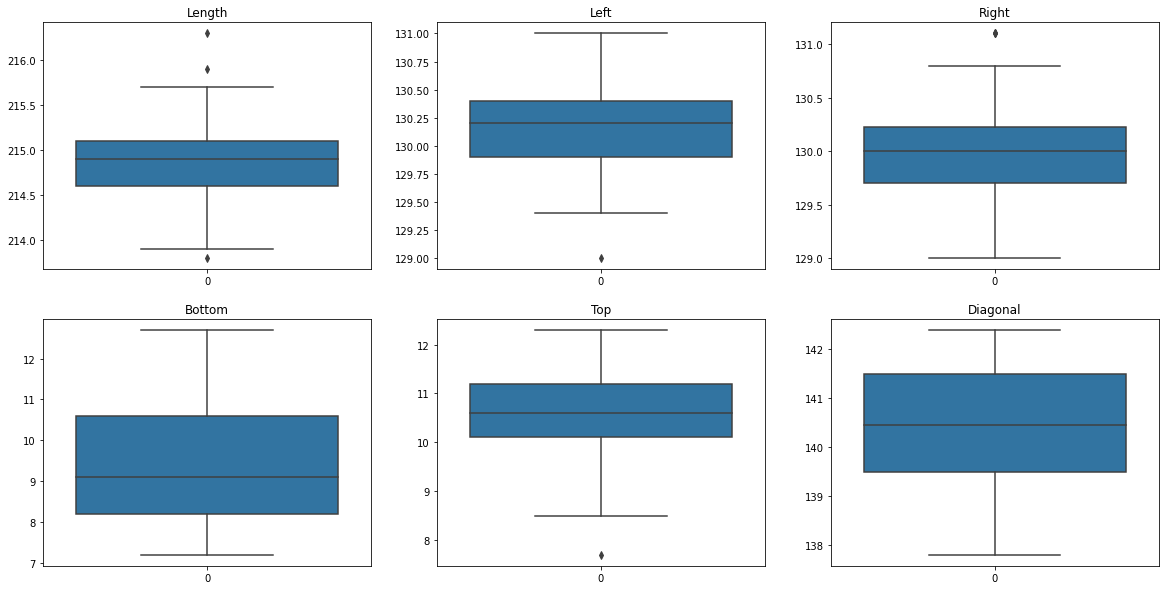

In [10]:
plt.figure(figsize=(20,10))
for count, column in enumerate(x.columns):
    plt.subplot(2, len(x.columns)/2, count+1)
    plt.title(column)
    plt.subplot(sns.boxplot(data=dataset[column]))
plt.show()
plt.close()

**análise:** quanto a normalidade, mais detalhes podem ser obtidos no gráfico QQ abaixo com o valor de alpha ajustado para 95%

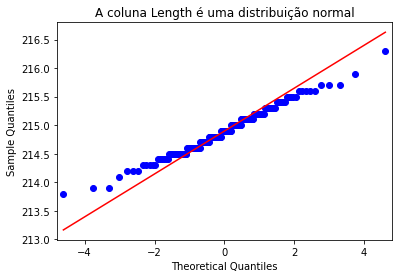

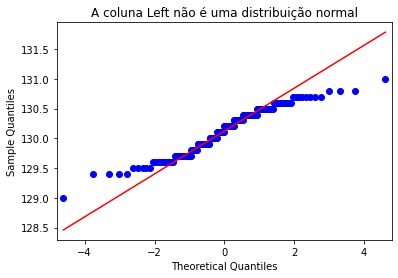

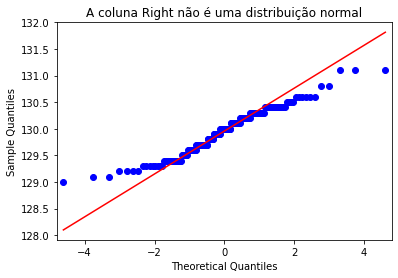

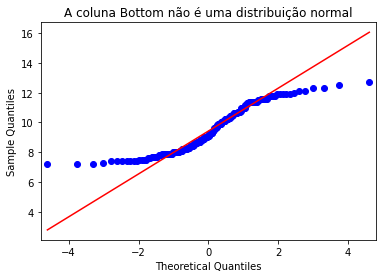

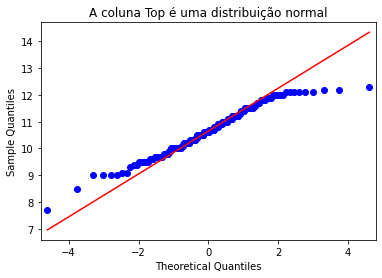

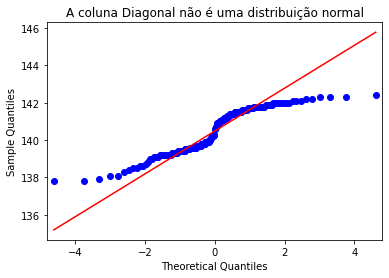

In [11]:
def isNormalDist(column, p):
    alpha = 0.05
    afirmative_text = 'A coluna {} é uma distribuição normal'.format(column)
    negative_text = 'A coluna {} não é uma distribuição normal'.format(column)
    return afirmative_text if p > alpha else negative_text

for column in x.columns:
    _, p = shapiro(dataset[column])
    fig = sm.qqplot(dataset[column], stats.t, distargs=(4,), line = 's')
    plt.title(isNormalDist(column, p))
    plt.show()

# 3. Treino do modelo - sem normalização, sem estudo de correlações, sem tratamento dos enviesamentos e sem testes de hipóteses, apenas para existir uma referência de melhoria de modelo

In [12]:
x

,Length,Left,Right,Bottom,Top,Diagonal
0,214.8,131.0,131.1,9.0,9.7,141.0
1,214.6,129.7,129.7,8.1,9.5,141.7
2,214.8,129.7,129.7,8.7,9.6,142.2
3,214.8,129.7,129.6,7.5,10.4,142.0
4,215.0,129.6,129.7,10.4,7.7,141.8
...,...,...,...,...,...,...
195,215.0,130.4,130.3,9.9,12.1,139.6
196,215.1,130.3,129.9,10.3,11.5,139.7
197,214.8,130.3,130.4,10.6,11.1,140.0
198,214.7,130.7,130.8,11.2,11.2,139.4


In [13]:
y

,conterfeit
0,0
1,0
2,0
3,0
4,0
...,...
195,1
196,1
197,1
198,1


In [14]:
def train(x, y):
    resultados_naive_bayes = []
    resultados_logistica = []
    resultados_forest = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x, 
                                                            y, 
                                                            test_size=0.3,
                                                            stratify = y,
                                                            random_state = i)
        naive_bayes = GaussianNB()
        naive_bayes.fit(x_train, y_train)
        resultados_naive_bayes.append(accuracy_score(y_test, naive_bayes.predict(x_test)))

        logistica = LogisticRegression()
        logistica.fit(x_train, y_train)
        resultados_logistica.append(accuracy_score(y_test, logistica.predict(x_test)))

        random_forest = RandomForestClassifier()
        random_forest.fit(x_train, y_train)
        resultados_forest.append(accuracy_score(y_test, random_forest.predict(x_test)))
    
    return np.array(resultados_naive_bayes), np.array(resultados_logistica), np.array(resultados_forest)

resultados_naive_bayes, resultados_logistica, resultados_forest = train(x, y)

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-14-41d79e0d2178>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(x_train, y_train)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), f

In [15]:
print("Média: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(resultados_naive_bayes.mean(), resultados_logistica.mean(), resultados_forest.mean()))
print("Desvio Padrão: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(np.std(resultados_naive_bayes), np.std(resultados_logistica), np.std(resultados_forest)))
print("Coeficiente de variação: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(stats.variation(resultados_naive_bayes), stats.variation(resultados_logistica), stats.variation(resultados_forest)))

Média: Naïve Bayes 0.99, Regressão Log. 0.99, Árvore de decisão 0.98833
Desvio Padrão: Naïve Bayes 0.008165, Regressão Log. 0.008165, Árvore de decisão 0.0076376
Coeficiente de variação: Naïve Bayes 0.0082474, Regressão Log. 0.0082474, Árvore de decisão 0.0077278


**Intervalo de confiança**

In [16]:
intervalos_naive = norm.interval(0.95, resultados_naive_bayes.mean(),stats.sem(resultados_naive_bayes))
intervalos_log = norm.interval(0.95, resultados_logistica.mean(),stats.sem(resultados_logistica))
intervalos_forest = norm.interval(0.95, resultados_forest.mean(),stats.sem(resultados_forest))

intervalos_naive, intervalos_log, intervalos_forest

((0.9846656536929386, 0.9953343463070614),
 (0.9846656536929386, 0.9953343463070614),
 (0.9833435092674766, 0.99332315739919))

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

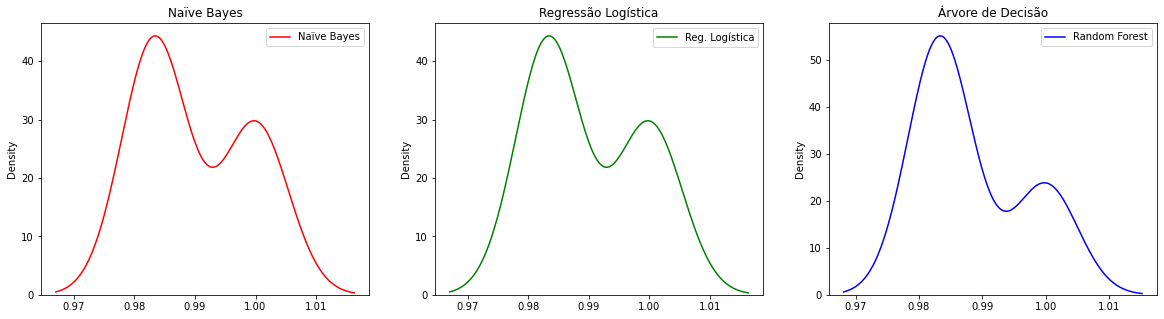

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title("Naïve Bayes")
plt.subplot(sns.distplot(resultados_naive_bayes, color="red", label="Naïve Bayes", hist=False, kde=True))
plt.legend();

plt.subplot(1, 3, 2)
plt.title("Regressão Logística")
plt.subplot(sns.distplot(resultados_logistica, color="green", label="Reg. Logística", hist=False, kde=True))
plt.legend();

plt.subplot(1, 3, 3)
plt.title("Árvore de Decisão")
plt.subplot(sns.distplot(resultados_forest, color="blue", label="Random Forest", hist=False, kde=True))
plt.legend();

# 4. Validação dos modelos com K-Fold - sem normalização, sem estudo de correlações, sem tratamento dos enviesamentos e sem testes de hipóteses

In [18]:
def train_kfold(x, y):
    resultados_naive_bayes = []
    resultados_logistica = []
    resultados_forest = []

    for i in range(10):
        kfold = KFold(n_splits = 10, shuffle = True, random_state = i)

        naive_bayes = GaussianNB()
        scores = cross_val_score(naive_bayes, x, y, cv = kfold)
        resultados_naive_bayes.append(scores.mean())

        logistica = LogisticRegression()
        scores = cross_val_score(logistica, x, y, cv = kfold)
        resultados_logistica.append(scores.mean())

        random_forest = RandomForestClassifier()
        scores = cross_val_score(random_forest, x, y, cv = kfold)
        resultados_forest.append(scores.mean())
        
    return np.array(resultados_naive_bayes), np.array(resultados_logistica), np.array(resultados_forest)

resultados_naive_bayes_kfold, resultados_logistica_kfold, resultados_forest_kfold = train_kfold(x, y)

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed w

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\utils\validatio

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\sklearn\model_selection

In [19]:
print("Média: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(resultados_naive_bayes_kfold.mean(), resultados_logistica_kfold.mean(), resultados_forest_kfold.mean()))
print("Desvio Padrão: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(np.std(resultados_naive_bayes_kfold), np.std(resultados_logistica_kfold), np.std(resultados_forest_kfold)))
print("Coeficiente de variação: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(stats.variation(resultados_naive_bayes_kfold), stats.variation(resultados_logistica_kfold), stats.variation(resultados_forest_kfold)))

Média: Naïve Bayes 0.995, Regressão Log. 0.995, Árvore de decisão 0.9915
Desvio Padrão: Naïve Bayes 1.1102e-16, Regressão Log. 1.1102e-16, Árvore de decisão 0.0022913
Coeficiente de variação: Naïve Bayes 1.1158e-16, Regressão Log. 1.1158e-16, Árvore de decisão 0.0023109


In [20]:
intervalos_naive = norm.interval(0.95, resultados_naive_bayes_kfold.mean(),stats.sem(resultados_naive_bayes_kfold))
intervalos_log = norm.interval(0.95, resultados_logistica_kfold.mean(),stats.sem(resultados_logistica_kfold))
intervalos_forest = norm.interval(0.95, resultados_forest_kfold.mean(),stats.sem(resultados_forest_kfold))

intervalos_naive, intervalos_log, intervalos_forest

((0.9949999999999997, 0.9949999999999999),
 (0.9949999999999997, 0.9949999999999999),
 (0.9900030527802429, 0.992996947219757))

C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

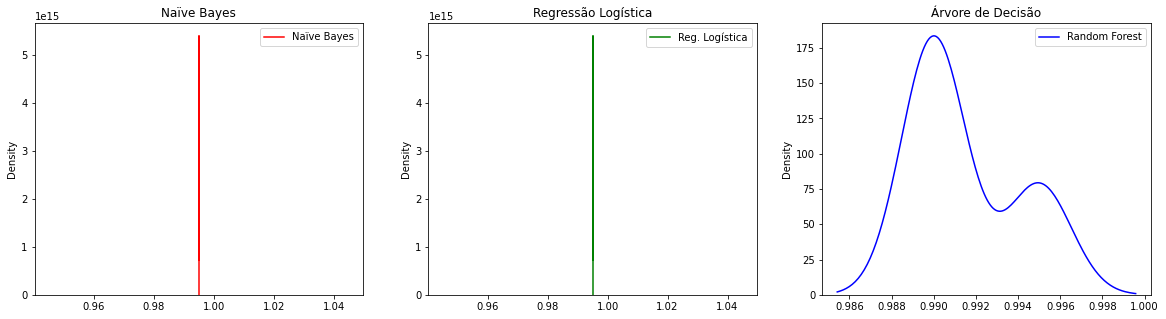

In [21]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title("Naïve Bayes")
plt.subplot(sns.distplot(resultados_naive_bayes_kfold, color="red", label="Naïve Bayes", hist=False, kde=True))
plt.legend();

plt.subplot(1, 3, 2)
plt.title("Regressão Logística")
plt.subplot(sns.distplot(resultados_logistica_kfold, color="green", label="Reg. Logística", hist=False, kde=True))
plt.legend();

plt.subplot(1, 3, 3)
plt.title("Árvore de Decisão")
plt.subplot(sns.distplot(resultados_forest_kfold, color="blue", label="Random Forest", hist=False, kde=True))
plt.legend();

# 5. Treino do modelo com normalização

In [22]:
def normalize_and_train(x, y):
    resultados_naive_bayes = []
    resultados_logistica = []
    resultados_forest = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x, 
                                                            y, 
                                                            test_size=0.3,
                                                            stratify = y,
                                                            random_state = i)
        for i in range(x.shape[1]):
            z_score_train = StandardScaler()
            z_score_test = StandardScaler()

            x_train[x_train.columns[i]] = z_score_train.fit_transform(x_train.iloc[:,i:i+1])
            x_test[x_test.columns[i]] = z_score_test.fit_transform(x_test.iloc[:,i:i+1])
        
        naive_bayes = GaussianNB()
        naive_bayes.fit(x_train, y_train)
        resultados_naive_bayes.append(accuracy_score(y_test, naive_bayes.predict(x_test)))
        
        logistica = LogisticRegression()
        logistica.fit(x_train, y_train)
        resultados_logistica.append(accuracy_score(y_test, logistica.predict(x_test)))

        random_forest = RandomForestClassifier()
        random_forest.fit(x_train, y_train)
        resultados_forest.append(accuracy_score(y_test, random_forest.predict(x_test)))
    return [np.array(resultados_naive_bayes), 
            np.array(resultados_logistica), 
            np.array(resultados_forest),
            naive_bayes.predict(x_test),
            logistica.predict(x_test),
            random_forest.predict(x_test),
            y_test]

In [23]:
resultados_naive_bayes_norm, resultados_logistica_norm, resultados_forest_norm, previsoes_naive, previsoes_log, previsoes_forest, y_test = normalize_and_train(x, y);

<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[x_train.columns[i]] = z_score_train.fit_transform(x_train.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[x_test.columns[i]] = z_score_test.fit_transform(x_test.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[x_train.columns[i]] = z_score_train.fit_transform(x_train.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[x_test.columns[i]] = z_score_test.fit_transform(x_test.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[x_train.columns[i]] = z_score_train.fit_transform(x_train.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[x_test.columns[i]] = z_score_test.fit_transform(x_test.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[x_train.columns[i]] = z_score_train.fit_transform(x_train.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[x_test.columns[i]] = z_score_test.fit_transform(x_test.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[x_train.columns[i]] = z_score_train.fit_transform(x_train.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[x_test.columns[i]] = z_score_test.fit_transform(x_test.iloc[:,i:i+1])
<ipython-input-22-b5c6ae6a03ce>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

<AxesSubplot:title={'center':'Árvore de Decisão'}>

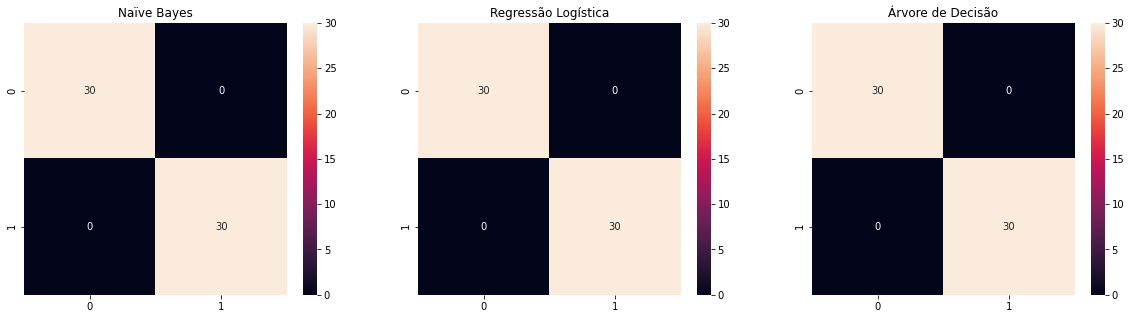

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title("Naïve Bayes")
plt.subplot(sns.heatmap(confusion_matrix(previsoes_naive, y_test), annot=True))
plt.subplot(1, 3, 2)
plt.title("Regressão Logística")
plt.subplot(sns.heatmap(confusion_matrix(previsoes_log, y_test), annot=True))
plt.subplot(1, 3, 3)
plt.title("Árvore de Decisão")
plt.subplot(sns.heatmap(confusion_matrix(previsoes_forest, y_test), annot=True))

In [25]:
print("Média: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(resultados_naive_bayes_norm.mean(), resultados_logistica_norm.mean(), resultados_forest_norm.mean()))
print("Desvio Padrão: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(np.std(resultados_naive_bayes_norm), np.std(resultados_logistica_norm), np.std(resultados_forest_norm)))
print("Coeficiente de variação: Naïve Bayes {:.5}, Regressão Log. {:.5}, Árvore de decisão {:.5}".format(stats.variation(resultados_naive_bayes_norm), stats.variation(resultados_logistica_norm), stats.variation(resultados_forest_norm)))

Média: Naïve Bayes 0.99, Regressão Log. 0.99, Árvore de decisão 0.99
Desvio Padrão: Naïve Bayes 0.008165, Regressão Log. 0.008165, Árvore de decisão 0.008165
Coeficiente de variação: Naïve Bayes 0.0082474, Regressão Log. 0.0082474, Árvore de decisão 0.0082474


C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\vinicius\anaconda3\envs\simples\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

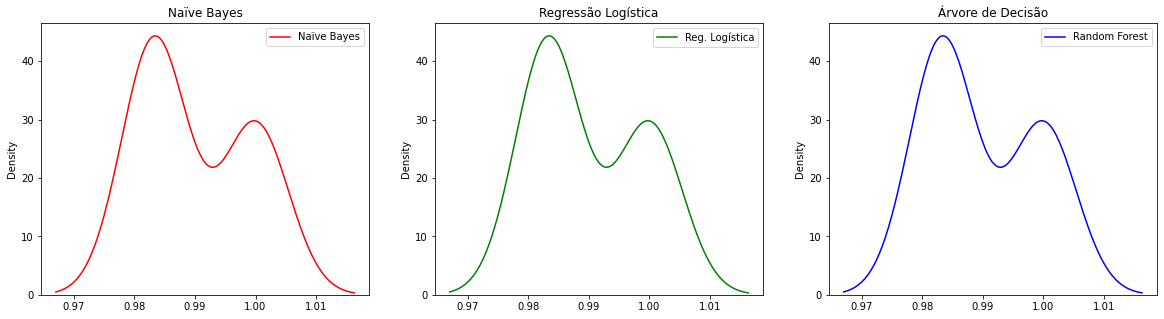

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title("Naïve Bayes")
plt.subplot(sns.distplot(resultados_naive_bayes_norm, color="red", label="Naïve Bayes", hist=False, kde=True))
plt.legend();

plt.subplot(1, 3, 2)
plt.title("Regressão Logística")
plt.subplot(sns.distplot(resultados_logistica_norm, color="green", label="Reg. Logística", hist=False, kde=True))
plt.legend();

plt.subplot(1, 3, 3)
plt.title("Árvore de Decisão")
plt.subplot(sns.distplot(resultados_forest_norm, color="blue", label="Random Forest", hist=False, kde=True))
plt.legend();